<a href="https://colab.research.google.com/github/Deepak-Mewada/Advance-Machine-Learning/blob/main/tutorials/W2D2_NeuroSymbolicMethods/student/W2D2_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 3: Representations in continuous space

**Week 2, Day 2: Neuro-Symbolic Methods**

**By Neuromatch Academy**

__Content creators:__ P. Michael Furlong, Chris Eliasmith

__Content reviewers:__ Hlib Solodzhuk, Patrick Mineault, Aakash Agrawal, Alish Dipani, Hossein Rezaei, Yousef Ghanbari, Mostafa Abdollahi

__Production editors:__ Konstantine Tsafatinos, Ella Batty, Spiros Chavlis, Samuele Bolotta, Hlib Solodzhuk

___


# Tutorial Objectives

*Estimated timing of tutorial: 40 minutes*

In this tutorial, you will observe how the VSA methods can be applied in structures and environments to allow for efficient generalization.

In [1]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today

from IPython.display import IFrame
link_id = "2szmk"

print(f"If you want to download the slides: 'https://osf.io/download/{link_id}'")

IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{link_id}/?direct%26mode=render", width=854, height=480)

If you want to download the slides: 'https://osf.io/download/2szmk'


---
# Setup



In [2]:
# @title Install and import feedback gadget

!pip install --quiet jupyter numpy matplotlib ipywidgets scikit-learn tqdm vibecheck

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_neuroai",
            "user_key": "wb2cxze8",
        },
    ).render()


feedback_prefix = "W2D2_T3"

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 7.4 MB/s eta 0:00:00


In [3]:
# @title Install dependencies
# @markdown

# Install sspspace
!pip install git+https://github.com/ctn-waterloo/sspspace@neuromatch --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 26.2 MB/s eta 0:00:00


In [4]:
# @title Imports

#working with data
import numpy as np

#plotting
import matplotlib.pyplot as plt
import logging

#interactive display
import ipywidgets as widgets

#modeling
import sspspace
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm as tqdm

In [5]:
# @title Figure settings

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [6]:
# @title Plotting functions

def plot_3d_function(X, Y, zs, titles):
    """Plot 3D function.

    Inputs:
    - X (list): list of np.ndarray of x-values.
    - Y (list): list of np.ndarray of y-values.
    - zs (list): list of np.ndarray of z-values.
    - titles (list): list of titles of the plot.
    """
    with plt.xkcd():
        fig = plt.figure(figsize=(8, 8))
        for index, (x, y, z) in enumerate(zip(X, Y, zs)):
            fig.add_subplot(1, len(X), index + 1, projection='3d')
            plt.gca().plot_surface(x,y,z.reshape(x.shape),cmap='plasma', antialiased=False, linewidth=0)
            plt.xlabel(r'$x_{1}$')
            plt.ylabel(r'$x_{2}$')
            plt.gca().set_zlabel(r'$f(\mathbf{x})$')
            plt.title(titles[index])
        plt.show()

def plot_performance(bound_performance, bundle_performance, training_samples, title):
    """Plot RMSE values for two different representations of the input data.

    Inputs:
    - bound_performance (list): list of RMSE for bound representation.
    - bundle_performance (list): list of RMSE for bundle representation.
    - training_samples (list): x-axis.
    - title (str): title of the plot.
    """
    with plt.xkcd():
        plt.plot(training_samples, bound_performance, label='Bound Representation')
        plt.plot(training_samples, bundle_performance, label='Bundling Representation', ls='--')
        plt.legend()
        plt.title(title)
        plt.ylabel('RMSE (a.u.)')
        plt.xlabel('# Training samples')

def plot_2d_similarity(sims, obj_names, size, title_argmax = False):
    """
    Plot 2D similarity between query points (grid) and the ones associated with the objects.

    Inputs:
    - sims (list): list of similarity values for each of the objects.
    - obj_names (list): list of object names.
    - size (tuple): to reshape the similarities.
    - title_argmax (bool, default = False): looks for the point coordinates as arg max from all similarity value.
    """
    ticks = [0, 24, 49, 74, 99]
    ticklabels = [-5, -2, 0, 2, 5]
    with plt.xkcd():
        for obj_idx, obj in enumerate(obj_names):
            plt.subplot(1, len(obj_names), 1 + obj_idx)
            plt.imshow(np.array(sims[obj_idx].reshape(size)), origin='lower', vmin=-1, vmax=1)
            plt.gca().set_xticks(ticks)
            plt.gca().set_xticklabels(ticklabels)
            if obj_idx == 0:
                plt.gca().set_yticks(ticks)
                plt.gca().set_yticklabels(ticklabels)
            else:
                plt.gca().set_yticks([])
            if not title_argmax:
                plt.title(f'{obj}, {positions[obj_idx]}')
            else:
                plt.title(f'{obj}, {query_xs[sims[obj_idx].argmax()]}')

def plot_unbinding_objects_map(sims, positions, query_xs, size):
    """
    Plot 2D similarity between query points (grid) and the unbinded from the objects map.

    Inputs:
    - sims (np.ndarray): similarity values for each of the query points with the map.
    - positions (np.ndarray): positions of the objects.
    - query_xs (np.ndarray): grid points.
    - size (tuple): to reshape the similarities.

    """
    ticks = [0,24,49,74,99]
    ticklabels = [-5,-2,0,2,5]
    with plt.xkcd():
        plt.imshow(sims.reshape(size), origin='lower')

        for idx, marker in enumerate(['o','s','^']):
            plt.scatter(*get_coordinate(positions[idx,:], query_xs, size), marker=marker,s=100)

        plt.gca().set_xticks(ticks)
        plt.gca().set_xticklabels(ticklabels)
        plt.gca().set_yticks(ticks)
        plt.gca().set_yticklabels(ticklabels)
        plt.title(f'All Object Locations')
        plt.show()

def plot_unbinding_positions_map(sims, positions, obj_names):
    """
    Plot 2D similarity between query points (grid) and the unbinded from the positions map.

    Inputs:
    - sims (np.ndarray): similarity values for each of the query points with the map.
    - positions (np.ndarray): test positions to query.
    - obj_names (list): names of the objects for labels.
    - size (tuple): to reshape the similarities.
    """
    with plt.xkcd():
        plt.figure(figsize=(8, 4))
        for pos_idx, pos in enumerate(positions):
            plt.subplot(1,len(test_positions), 1+pos_idx)
            plt.bar([1,2,3], sims[pos_idx])
            plt.ylim([-0.3, 1.05])
            plt.gca().set_xticks([1,2,3])
            plt.gca().set_xticklabels(obj_names, rotation=90)
            if pos_idx != 0:
                plt.gca().set_yticks([])
            plt.title(f'Symbols at\n{pos}')
        plt.show()

In [7]:
# @title Helper functions

def get_model(xs, ys, train_size):
    """Fit linear regression to the given data.

    Inputs:
    - xs (np.ndarray): input data.
    - ys (np.ndarray): output data.
    - train_size (float): fraction of data to use for train.
    """
    X_train, _, y_train, _ = train_test_split(xs, ys, random_state=1, train_size=train_size)
    return LinearRegression().fit(X_train, y_train)

def get_coordinate(x, positions, target_shape):
    """Return the closest column and row coordinates for the given position.

    Inputs:
    - x (np.ndarray): query position.
    - positions (np.ndarray): all positions.
    - target_shape (tuple): shape of the grid.

    Outputs:
    - coordinates (tuple): column and row positions.
    """
    idx = np.argmin(np.linalg.norm(x - positions, axis=1))
    c = idx % target_shape[1]
    r = idx // target_shape[1]
    return (c,r)

In [8]:
# @title Set random seed

import random
import numpy as np

def set_seed(seed=None):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)

set_seed(seed = 42)

---

# Section 1: Sample Efficient Learning

In this section, we will take a look at how imposing an inductive bias on our feature space can result in more sample-efficient learning.

In [9]:
# @title Video 1: Function Learning and Inductive Bias

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'KDKmDjMxU7Q'), ('Bilibili', 'BV1GM4m1S7kT')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [10]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_function_learning_and_inductive_bias")

## Coding Exercise 1: Additive Function


We will start with an additive function, the Rastrigin function, defined

\begin{align*}
f(\mathbf{x}) = 10d + \sum_{i=1}^{d} (x_{i}^{2} - 10 \cos(2 \pi x_{i}))
\end{align*}

where $d$ is the dimensionality of the input vector. In the cell below, complete missing parts of the function which computes values of the Rastrigin function given the input array.

In [12]:
###################################################################
## Fill out the following then remove
#raise NotImplementedError("Student exercise: complete the Rastrigin function.")
###################################################################

def rastrigin(x):
    """Compute Rastrigin function for given array of d-dimenstional vectors.

    Inputs:
    - x (np.ndarray of shape (n, d)): n d-dimensional vectors.

    Outputs:
    - y (np.ndarray of shape (n, 1)): Rastrigin function value for each of the vectors.
    """
    return 10 * x.shape[1] + np.sum(x**2 - 10 * np.cos(2*np.pi*x), axis=1)

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D2_NeuroSymbolicMethods/solutions/W2D2_Tutorial3_Solution_67fd1d5c.py)



In [13]:
# this code creates 10000 2-dimensional vectors which are going to be served as input to the function (thus, output is of shape (10000, 1))
x0 = np.linspace(-5.12, 5.12, 100)
X, Y = np.meshgrid(x0,x0)
xs = np.vstack((X.flatten(), Y.flatten())).T

ys_rastrigin = rastrigin(xs)

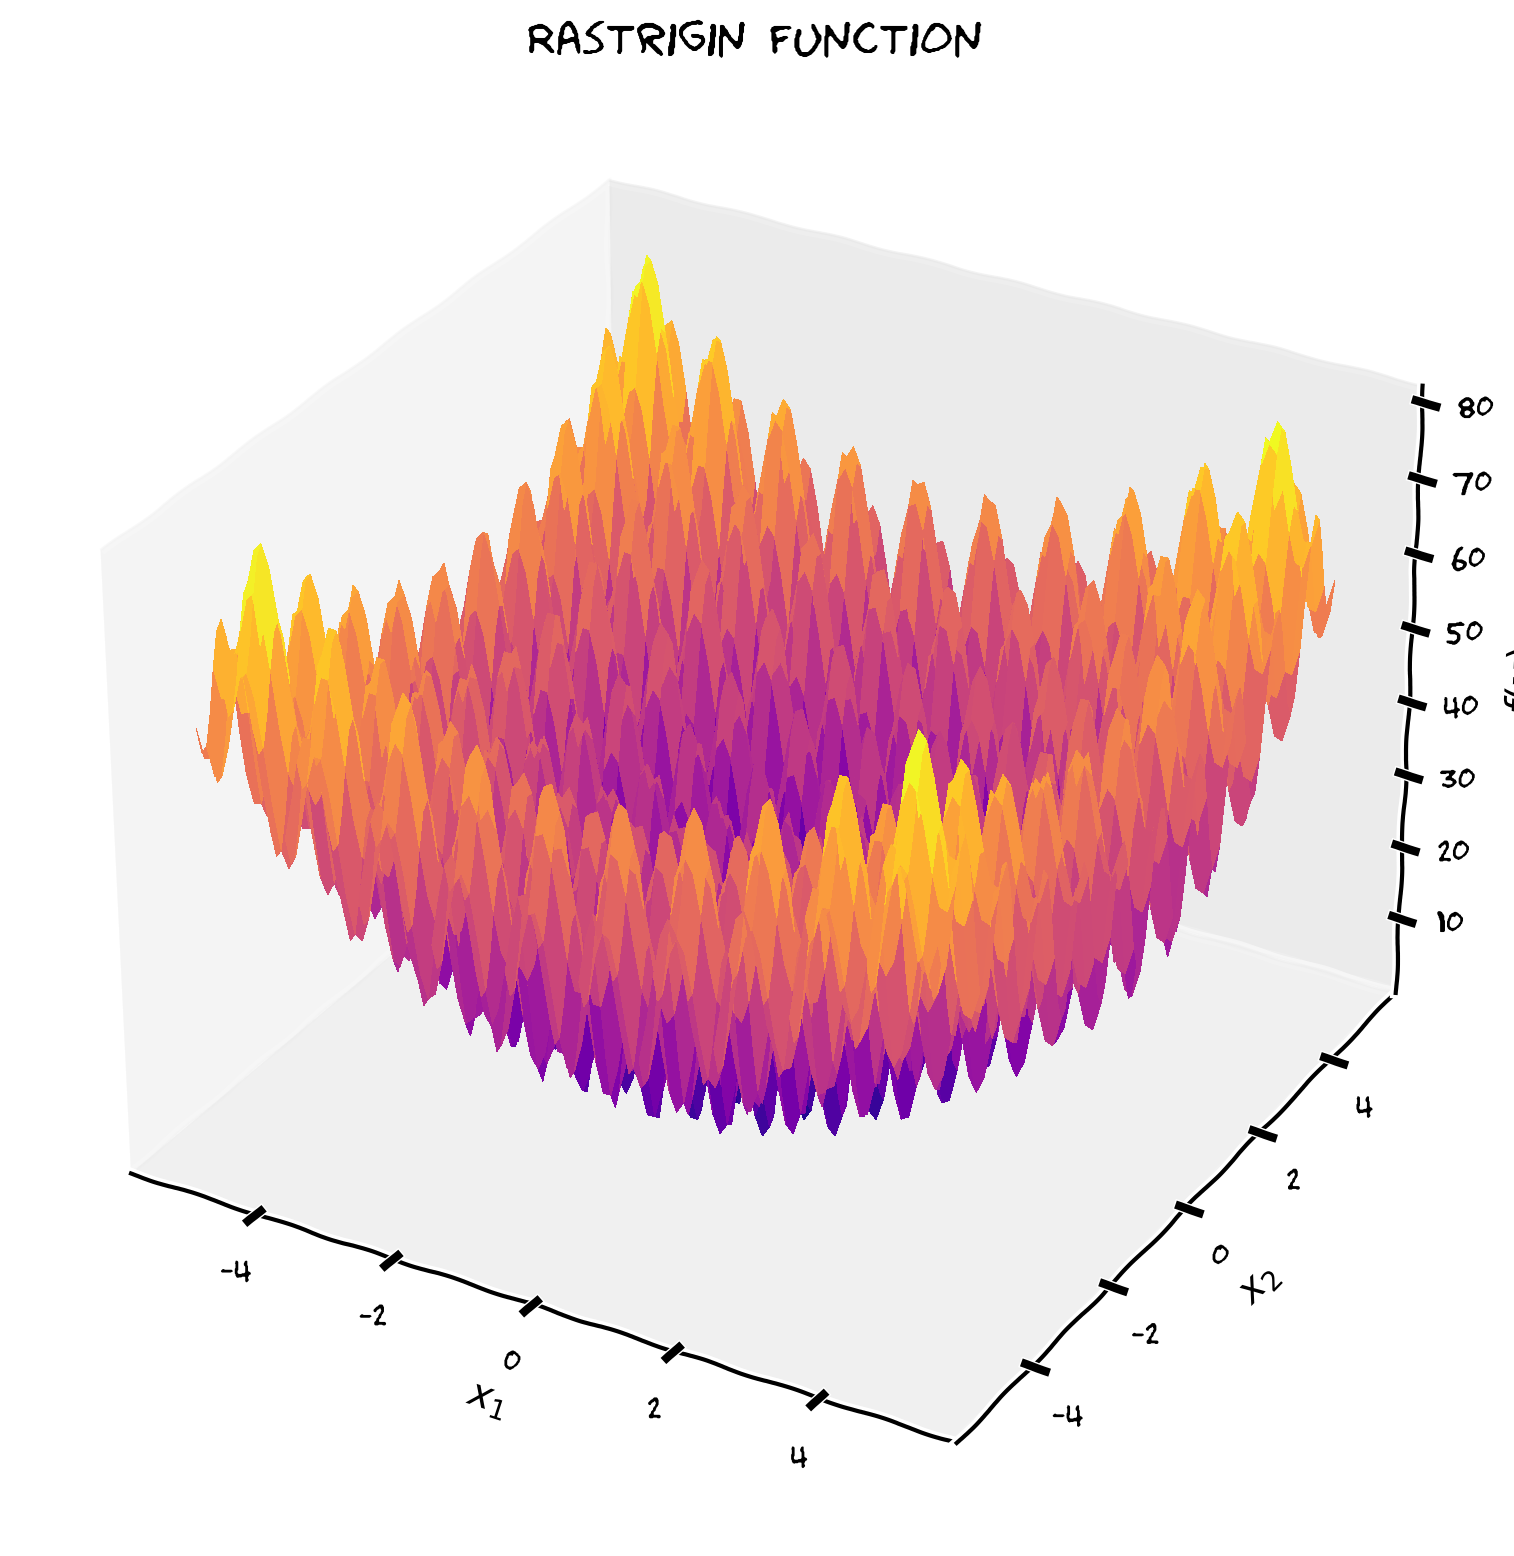

In [14]:
plot_3d_function([X],[Y], [ys_rastrigin.reshape(X.shape)], ['Rastrigin Function'])

Now, we are going to see which of the inductive biases (suggested mechanism underlying input data) will be more efficient in training the linear regression to get values of the Rastrigin function. We will consider two representations:

* **Bound**: We encode 2D input vectors `xs` as bound vectors
* **Bundled**: We encode 1D input vectors separately and use bundling and then bundle them together

In [15]:
set_seed(42)

ssp_space = sspspace.RandomSSPSpace(domain_dim=2, ssp_dim=1024)
bound_phis = ssp_space.encode(xs)

ssp_space0 = sspspace.RandomSSPSpace(domain_dim=1, ssp_dim=1024)
ssp_space1 = sspspace.RandomSSPSpace(domain_dim=1, ssp_dim=1024)

#remember that input to `encode` should be 2-dimensional, thus we need to create extra dimension by applying [:,None]
bundle_phis = ssp_space0.encode(xs[:, 0][:, None]) + ssp_space1.encode(xs[:, 1][:, None])

Now, let us define modeling attributes: we will have a few different `train_sizes`, and we will fit a linear regression for each of them in a loop. Then, for each of the models, we will evaluate its fit based on RMSE loss on the test set.

In [16]:
def loss(y_true, y_pred):
    """Calculate RMSE loss between true and predicted values (note, that loss is not normalized by the shape).

    Inputs:
    - y_true (np.ndarray): true values.
    - y_pred (np.ndarray): predicted values.

    Outputs:
    - loss (float): loss value.
    """
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def test_performance(xs, ys, train_sizes):
    """Fit linear regression to the provided data and evaluate the performance with RMSE loss for different test sizes.

    Inputs:
    - xs (np.ndarray): input data.
    - ys (np.ndarray): output data.
    - train_size (list): list of the train sizes.
    """
    performance = []

    models = []
    for train_size in tqdm(train_sizes):
        X_train, X_test, y_train, y_test = train_test_split(xs, ys, random_state=1, train_size=train_size)
        regr = LinearRegression().fit(X_train, y_train)
        performance.append(np.copy(loss(y_test, regr.predict(X_test))))
        models.append(regr)
    return performance, models

Now, we are ready to train the models on two different inductive biases of the input data.

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

(-1.0, 20.0)

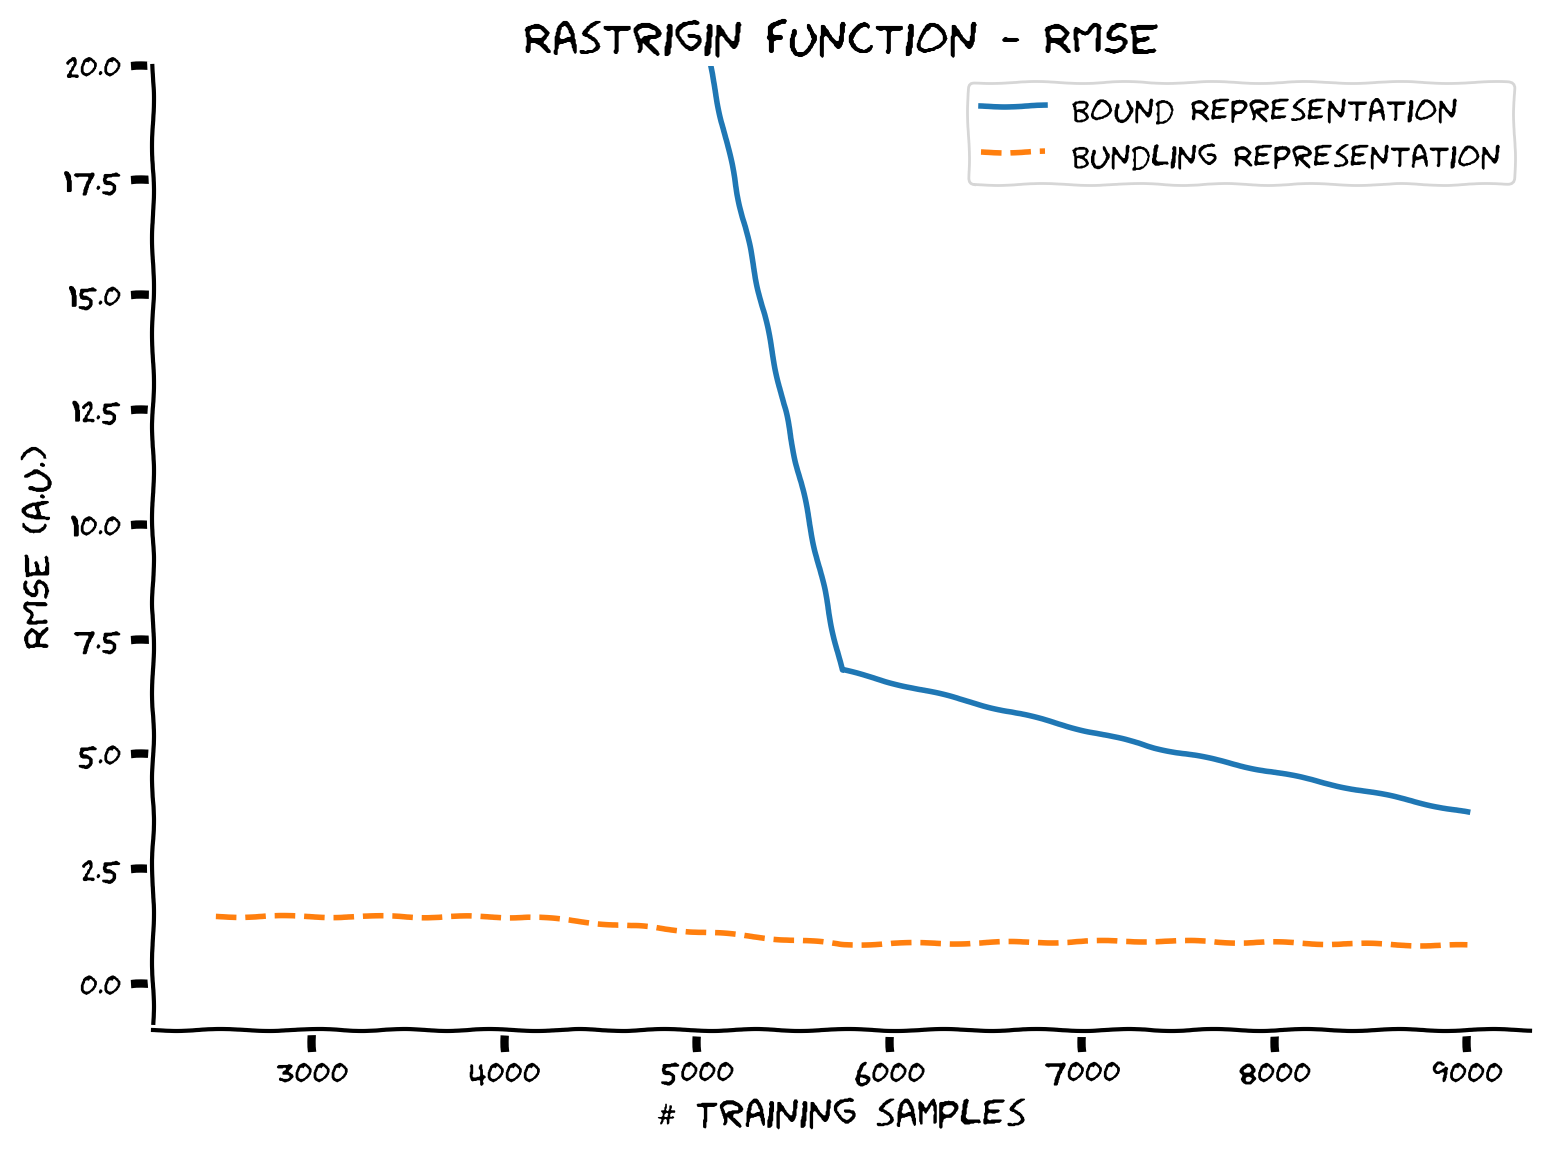

In [17]:
train_sizes = np.linspace(0.25, 0.9, 5)
bound_performance, bound_models = test_performance(bound_phis, ys_rastrigin, train_sizes)
bundle_performance, bundle_models = test_performance(bundle_phis, ys_rastrigin, train_sizes)
plot_performance(bound_performance, bundle_performance, train_sizes * bound_phis.shape[0], "Rastrigin function - RMSE")
plt.ylim((-1, 20))

What a drastic difference! Let us evaluate visually the performance when training on 3,000 train points.

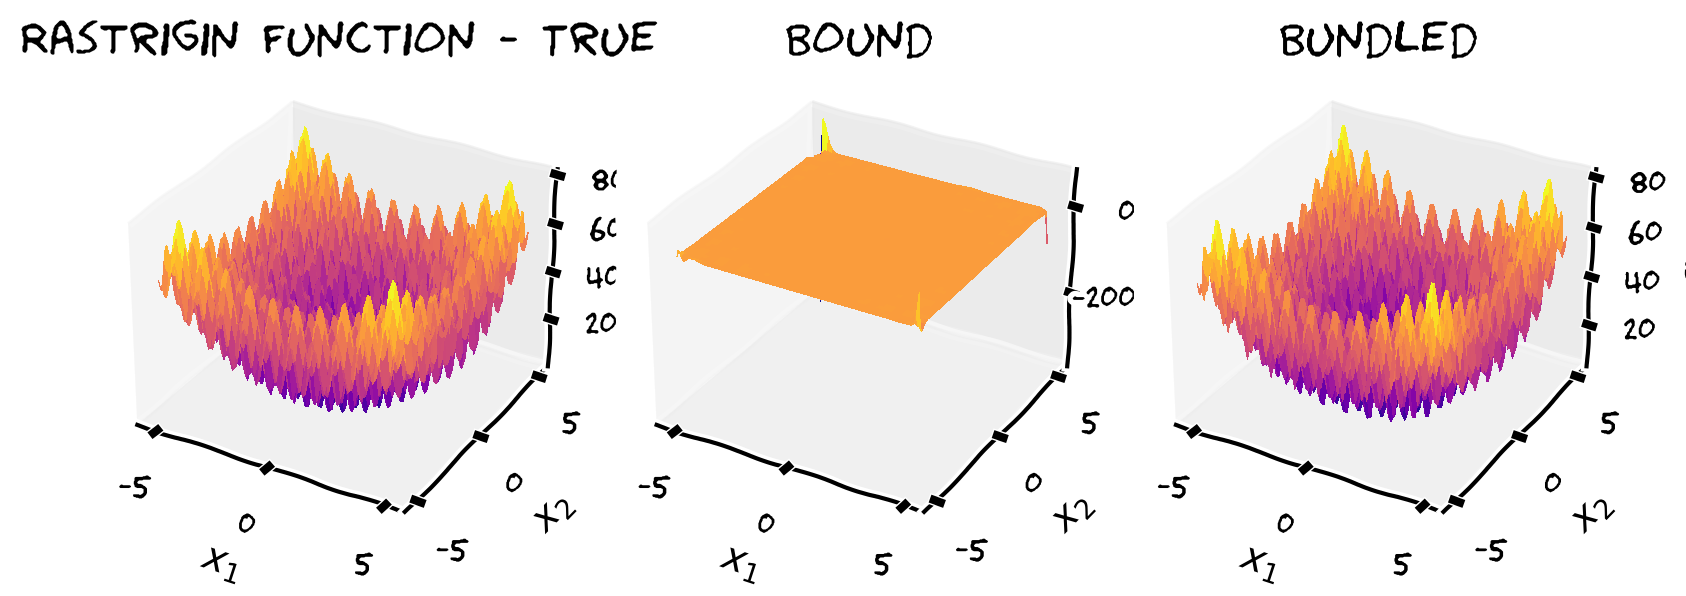

In [18]:
bound_model = bound_models[0]
bundled_model = bundle_models[0]

ys_hat_rastrigin_bound = bound_model.predict(bound_phis)
ys_hat_rastrigin_bundled = bundled_model.predict(bundle_phis)

plot_3d_function([X, X, X], [Y, Y, Y], [ys_rastrigin.reshape(X.shape), ys_hat_rastrigin_bound.reshape(X.shape), ys_hat_rastrigin_bundled.reshape(X.shape)], ['Rastrigin Function - True', 'Bound', 'Bundled'])

### Coding Exercise 1 Discussion

1. Why do you think the bundled representation is superior for the Rastrigin function?

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D2_NeuroSymbolicMethods/solutions/W2D2_Tutorial3_Solution_8c79265f.py)



In [19]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_additive_function")

## Coding Exercise 2: Non-separable Function

Now, let's consider a non-separable function: a function $f(x_1, x_2)$ that cannot be described as the sum of two one-dimensional functions $g(x_1)$ and $h_1$.  We will examine this function over the domain $[-4,4]^{2}$:

$$f(\mathbf{x}) = \sin(x_{1}x_{2})$$

Fill in the missing parts of the code to get the correct calculation of the defined function.

In [22]:
###################################################################
## Fill out the following then remove
#raise NotImplementedError("Student exercise: complete the non-separable function.")
###################################################################

def non_separable(x):
    """Compute non-separable function for given array of 2-dimenstional vectors.

    Inputs:
    - x (np.ndarray of shape (n, 2)): n 2-dimensional vectors.

    Outputs:
    - y (np.ndarray of shape (n, 1)): non-separable function value for each of the vectors.
    """
    return np.sin(np.multiply(x[:, 0], x[:, 1]))

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D2_NeuroSymbolicMethods/solutions/W2D2_Tutorial3_Solution_466dca90.py)



In [23]:
x0 = np.linspace(-4, 4, 100)
X, Y = np.meshgrid(x0,x0)
xs = np.vstack((X.flatten(), Y.flatten())).T

ys_non_separable = non_separable(xs)

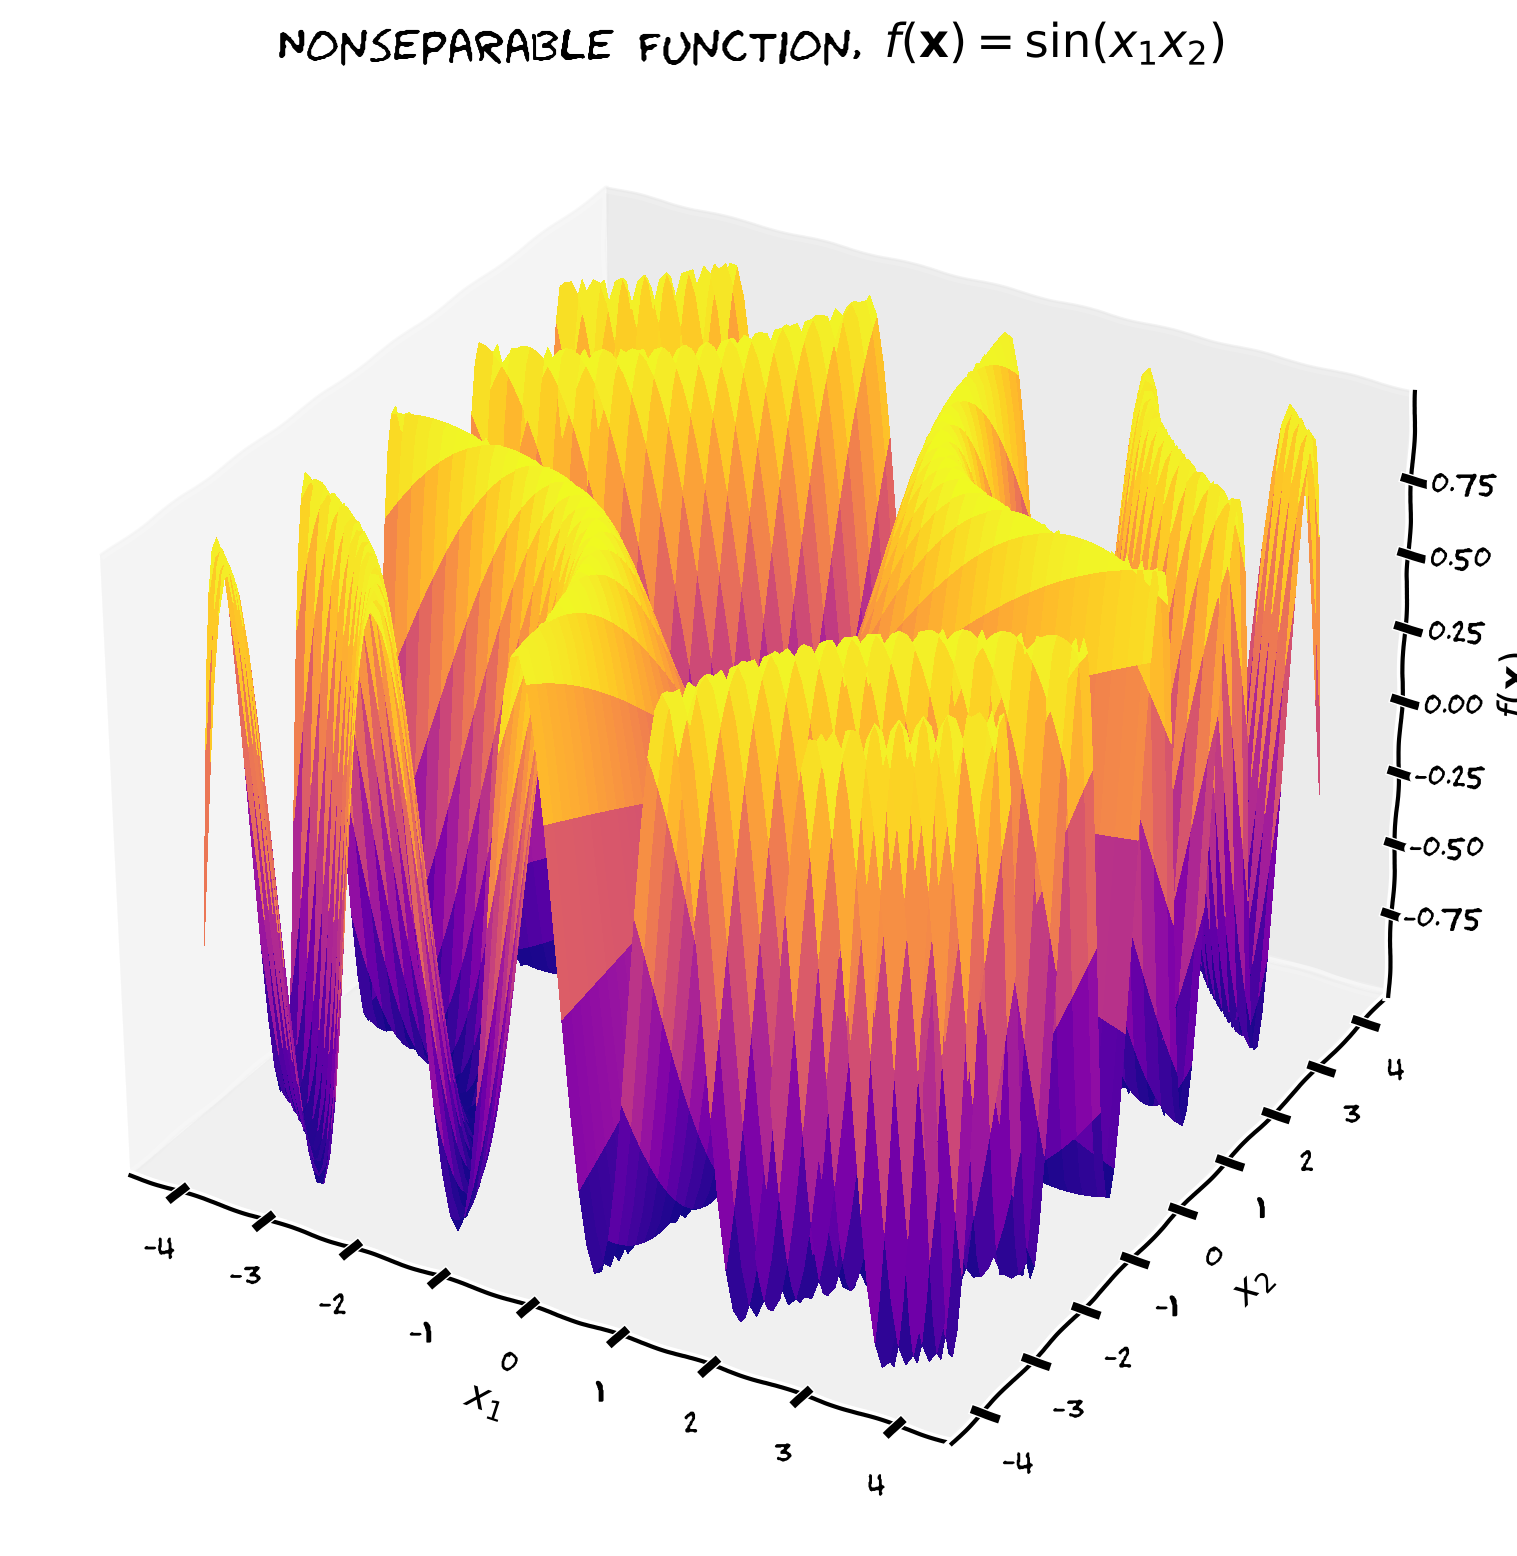

In [24]:
plot_3d_function([X],[Y], [ys_non_separable.reshape(X.shape)], ['Nonseparable Function, $f(\mathbf{x}) = \sin(x_{1}x_{2})$'])

### Coding Exercise 2 Discussion

1. Can you guess by the nature of the function which of the representations will be more efficient?

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D2_NeuroSymbolicMethods/solutions/W2D2_Tutorial3_Solution_2b4c5a99.py)



We will reuse previously defined spaces for encoding bound and bundled representations.

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

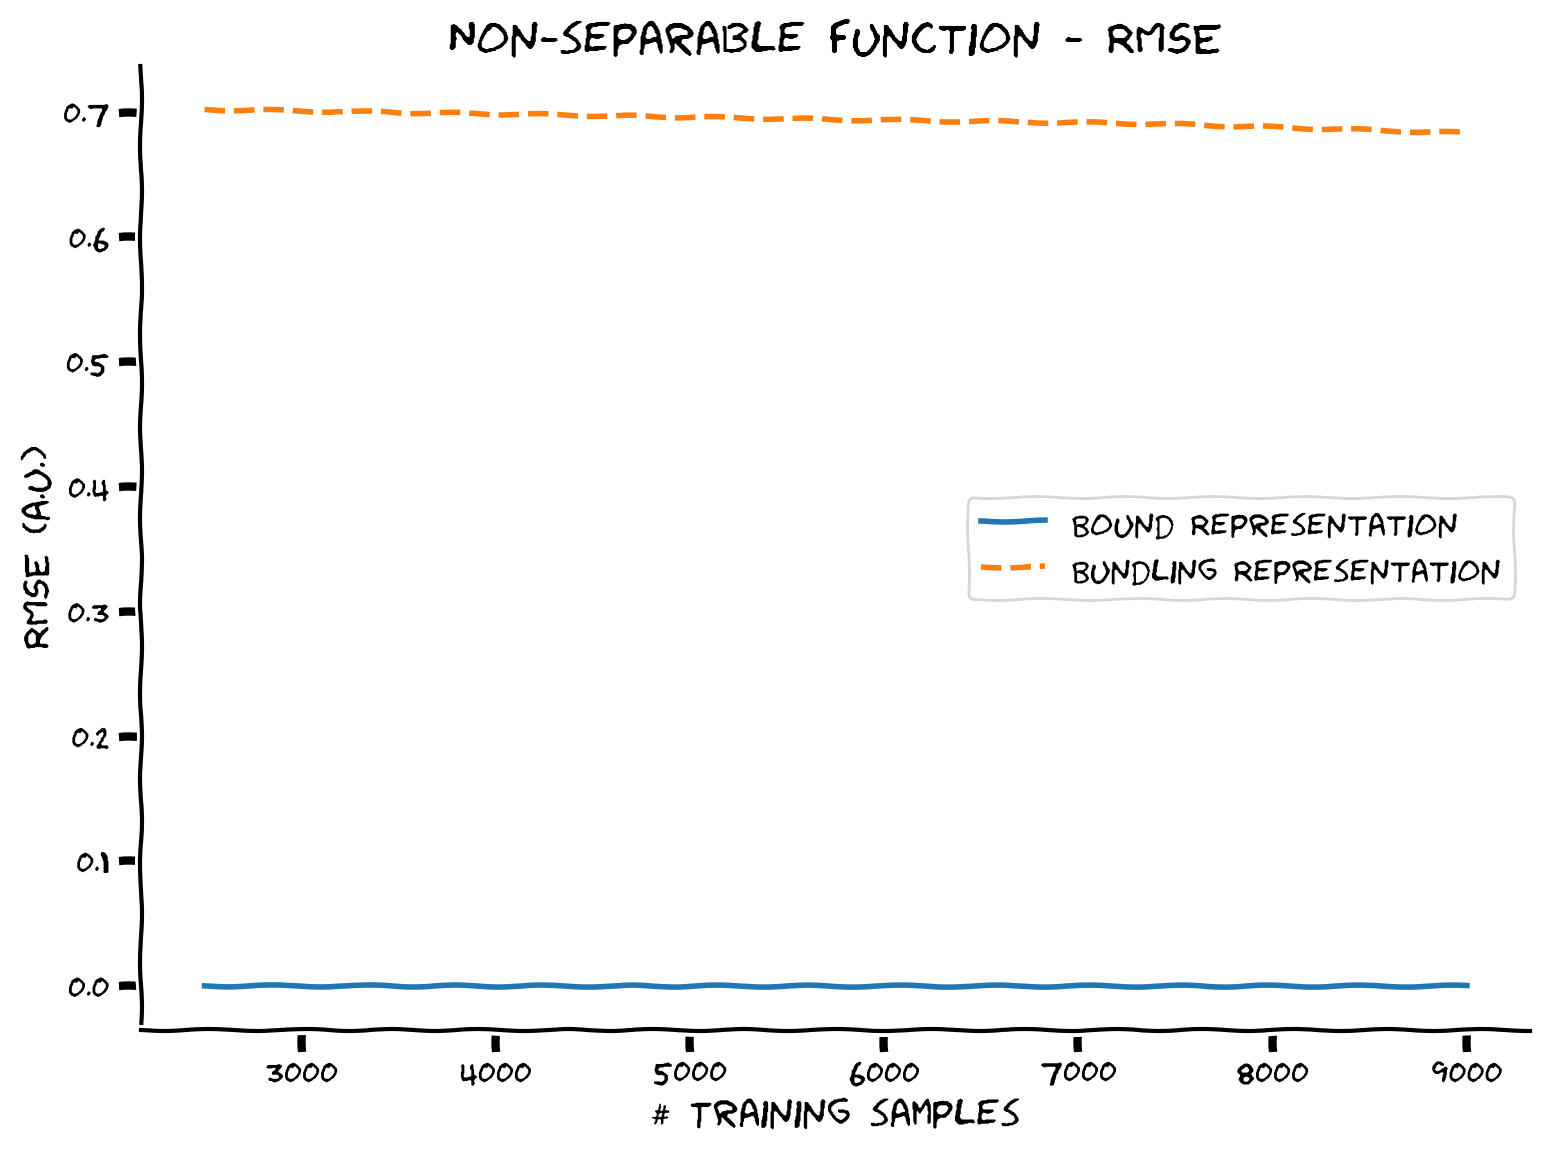

In [25]:
bound_phis = ssp_space.encode(xs)
bundle_phis = ssp_space0.encode(xs[:,0][:,None]) + ssp_space1.encode(xs[:,1][:,None])

train_sizes = np.linspace(0.25, 0.9, 5)
bound_performance, bound_models = test_performance(bound_phis, ys_non_separable, train_sizes)
bundle_performance, bundle_models = test_performance(bundle_phis, ys_non_separable, train_sizes)
plot_performance(bound_performance, bundle_performance, train_sizes * bound_phis.shape[0], title = "Non-separable function - RMSE")

Bundling representation can't achieve the same quality even when the number of samples is increased. This is because the function is non-separable, and the bundling representation can't capture the interaction between the two dimensions.

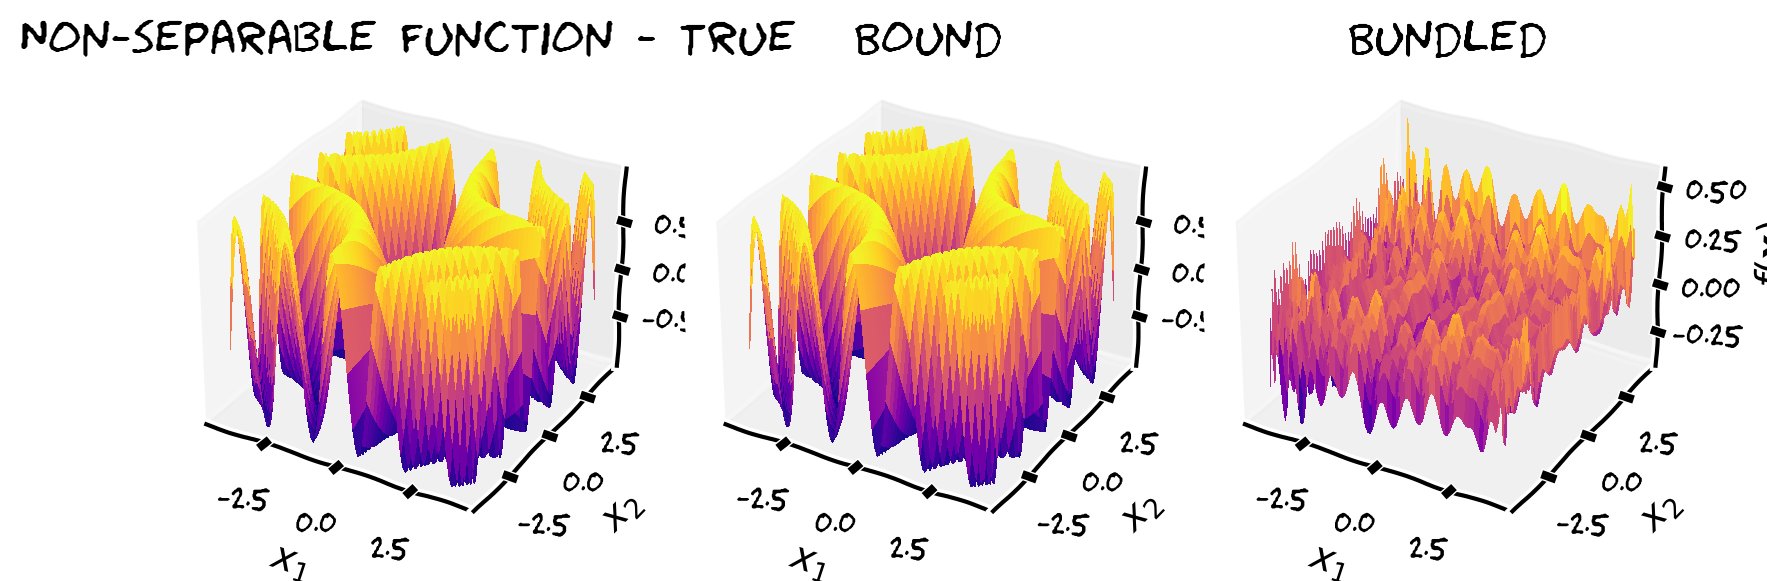

In [26]:
bound_model = bound_models[0]
bundle_model = bundle_models[0]

ys_hat_bound = bound_model.predict(bound_phis)
ys_hat_bundle = bundle_model.predict(bundle_phis)

plot_3d_function([X, X, X], [Y, Y, Y], [ys_non_separable.reshape(X.shape), ys_hat_bound.reshape(X.shape), ys_hat_bundle.reshape(X.shape)], ['Non-separable Function - True', 'Bound', 'Bundled'])

So, as we can see, when we pick the right inductive bias, we can do a better job.

In [27]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_non_separable_function")

---

# Section 2: Representing Continuous Values

Estimated timing to here from start of tutorial: 20 minutes

In this section we will use a technique called Fractional Binding to represent continuous values to construct a map of objects distributed over a 2D space.  

In [28]:
# @title Video 2: Mapping Intro
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 's7MOusrbKXU'), ('Bilibili', 'BV1pi421i7iN')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [29]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_mapping_intro")

## Coding Exercise 3: Mixing Discrete Objects With Continuous Space

We will store three objects in a vector representing a map. First, we will create 3 objects (a circle, square, and triangle), as we did before.

In [30]:
set_seed(42)

obj_names = ['circle','square','triangle']
discrete_space = sspspace.DiscreteSPSpace(obj_names, ssp_dim=1024)

objs = {n:discrete_space.encode(n) for n in obj_names}

Next, we are going to create three locations where the objects will reside, and an encoder will transform those coordinates into an SSP representation.

In [31]:
set_seed(42)

ssp_space = sspspace.RandomSSPSpace(domain_dim=2, ssp_dim=1024)
positions = np.array([[0, -2],
                      [-2, 3],
                      [3, 2]
                     ])
ssps = {n:ssp_space.encode(x) for n, x in zip(obj_names, positions)}

Next, in order to see where things are on the map, we are going to compute the similarity between encoded places and points in the space. Your task is to complete the calculation of similarity values between all grid points with the one associated with the object.

In [32]:
dim0 = np.linspace(-5, 5, 101)
dim1 = np.linspace(-5, 5, 101)
X,Y = np.meshgrid(dim0, dim1)

query_xs = np.vstack((X.flatten(), Y.flatten())).T
query_ssps = ssp_space.encode(query_xs)

In [34]:
###################################################################
## Fill out the following then remove
#raise NotImplementedError("Student exercise: complete similarity calculation.")
###################################################################

sims = []

for obj_idx, obj in enumerate(obj_names):
    sims.append(query_ssps @ ssps[obj].flatten())

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D2_NeuroSymbolicMethods/solutions/W2D2_Tutorial3_Solution_b6333869.py)



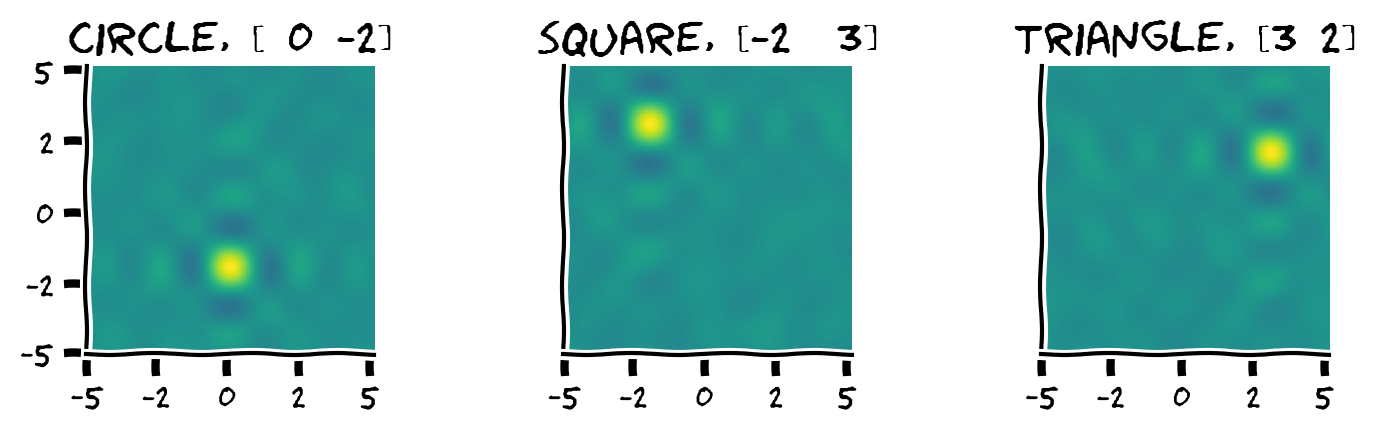

In [35]:
plt.figure(figsize=(8, 2.4))
plot_2d_similarity(sims, obj_names, (dim0.size, dim1.size))

Now, let's bind these positions with the objects and see how that changes similarity with the map positions. Complete binding operation in the cell below.

In [36]:
###################################################################
## Fill out the following then remove
#raise NotImplementedError("Student exercise: complete binding operation for objects and corresponding positions.")
###################################################################

#objects are located in `objs` and positions in `ssps`
bound_objects = [objs[n] * ssps[n] for n in obj_names]

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D2_NeuroSymbolicMethods/solutions/W2D2_Tutorial3_Solution_490cd369.py)



Now, we will calculate the similarity in the same way we did before.

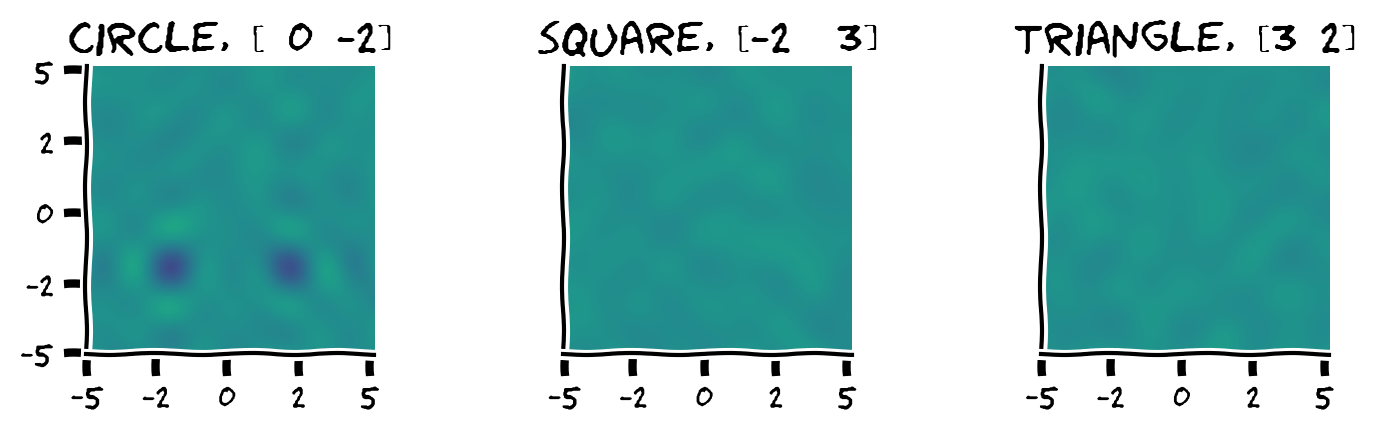

In [37]:
sims = []

for obj_idx, obj in enumerate(obj_names):
    sims.append(query_ssps @ bound_objects[obj_idx].flatten())

plt.figure(figsize=(8, 2.4))
plot_2d_similarity(sims, obj_names, (dim0.size, dim1.size))

As you can seem, the similarity is destroyed, which is what we should expect.

Next, we are going to create a map out of our bound objects:

\begin{align*}
\mathrm{map} = \sum_{i=1}^{n} \phi(x_{i})\circledast obj_{i}
\end{align*}

In [38]:
set_seed(42)

ssp_map = sspspace.SSP(np.sum(bound_objects, axis=0))

Now, we can query the map by unbinding the objects we care about. Your task is to complete the unbinding operation.

In [40]:
###################################################################
## Fill out the following then remove
#raise NotImplementedError("Student exercise: complete the unbinding operation.")
###################################################################

objects_sims = []

for obj_idx, obj_name in enumerate(obj_names):
    #query the object name by unbinding it from the map
    query_map = ssp_map * ~objs[obj_name]
    objects_sims.append(query_ssps @ query_map.flatten())

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D2_NeuroSymbolicMethods/solutions/W2D2_Tutorial3_Solution_2ffe8e1d.py)



Let's observe the resulting similarities.

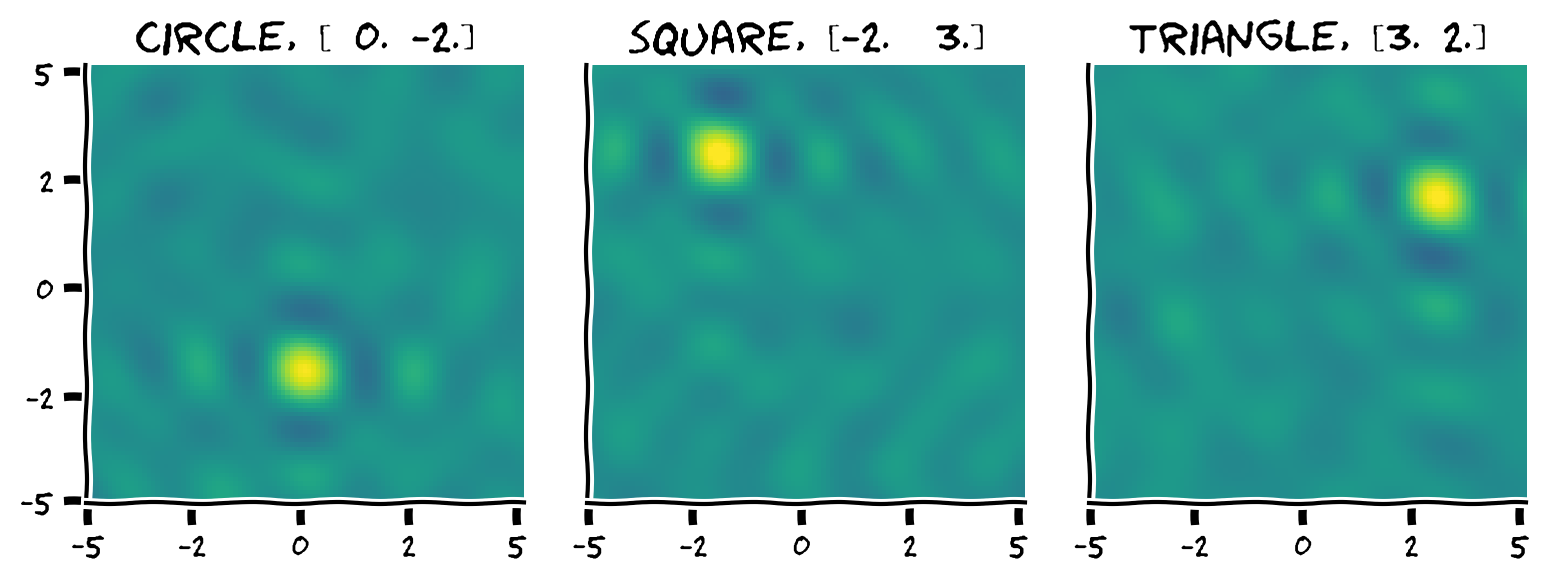

In [41]:
plot_2d_similarity(objects_sims, obj_names, (dim0.size, dim1.size), title_argmax = True)

Let's look at what happens when we unbind all the symbols from the map at once. Complete bundling and unbinding operations in the following code cell.

In [43]:
###################################################################
## Fill out the following then remove
#raise NotImplementedError("Student exercise: complete the bundling and unbinding operations.")
###################################################################

# unifying bundled representation of all objects
all_objs = (objs['circle'] + objs['triangle'] + objs['square']).normalize()

# unbind this unifying representation from the map
query_map = ssp_map * ~all_objs

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D2_NeuroSymbolicMethods/solutions/W2D2_Tutorial3_Solution_d0e65e39.py)



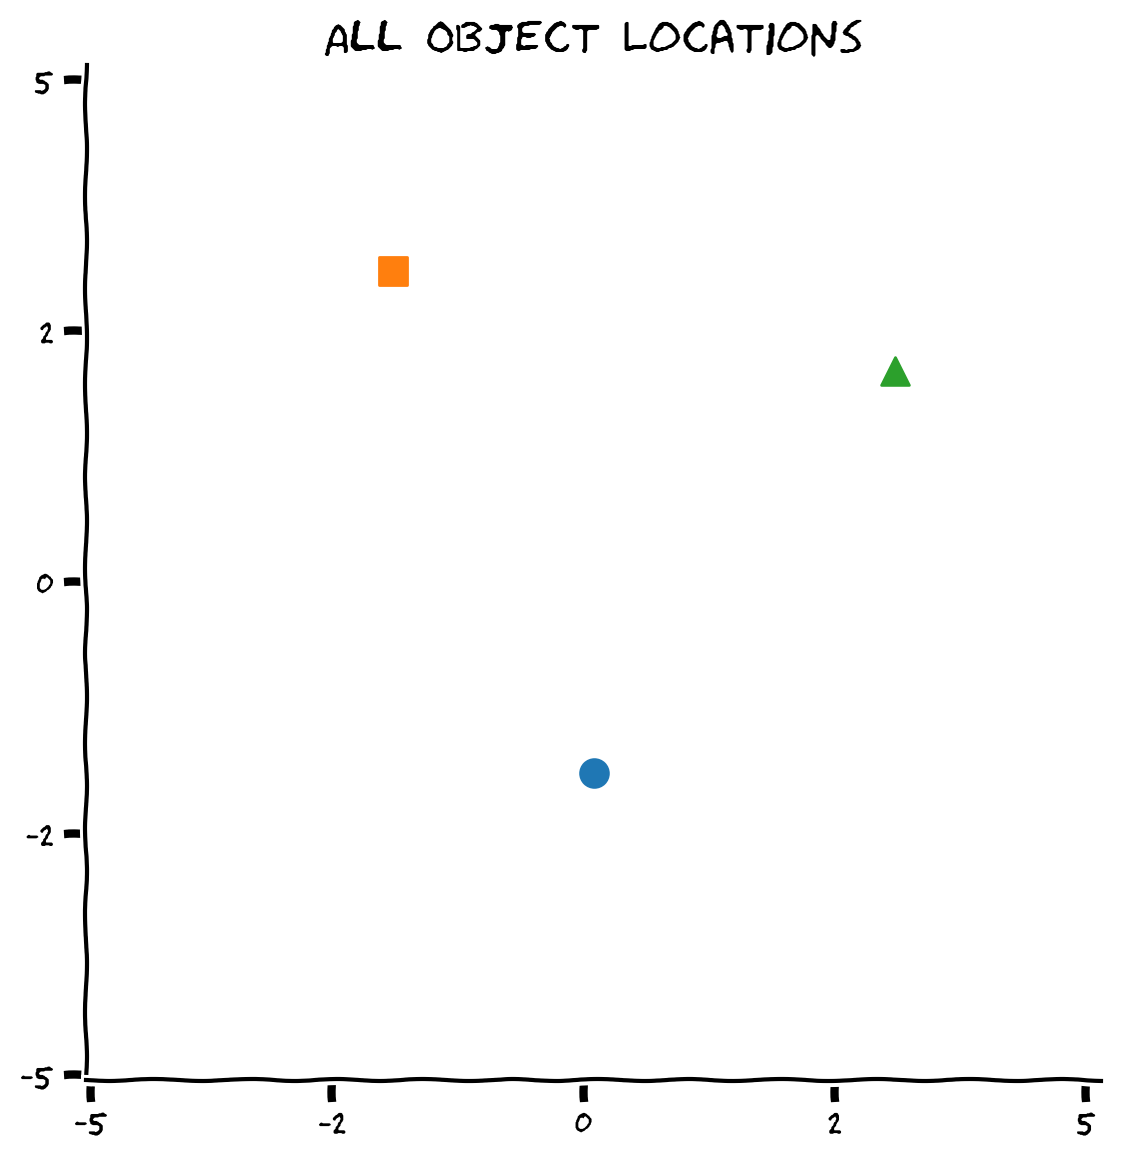

In [44]:
sims = query_ssps @ query_map.flatten()
size = (dim0.size,dim1.size)

plot_unbinding_objects_map(sims, positions, query_xs, size)

We can also unbind positions and see what objects exist there. We will the locations where objects are located as test positions, as well as two distinct ones to compare. In the final exercise, you should complete the unbinding of the position's operation.

In [47]:
###################################################################
## Fill out the following then remove
#raise NotImplementedError("Student exercise: complete the unbinding operations.")
###################################################################

query_objs = np.vstack([objs[n] for n in obj_names])
test_positions = np.vstack((positions, [0,0], [0,-1.5]))

sims = []

for pos_idx, pos in enumerate(test_positions):
    position_ssp = ssp_space.encode(pos[None,:]) #remember we need to have 2-dimensional vectors for `encode()` function
    #unbind positions from the map
    query_map = ssp_map * ~position_ssp
    sims.append(query_objs @ query_map.flatten())

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D2_NeuroSymbolicMethods/solutions/W2D2_Tutorial3_Solution_7700e7bf.py)



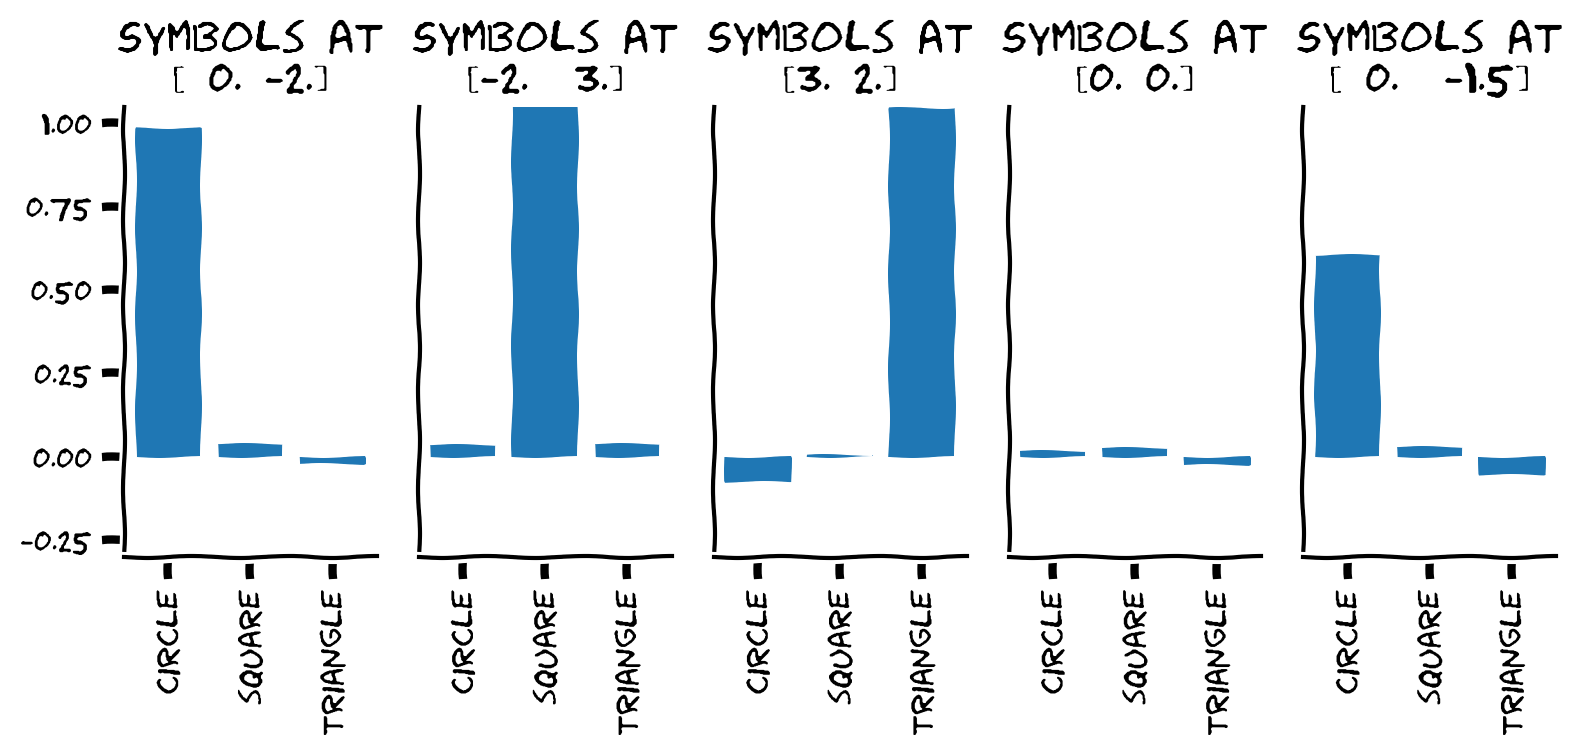

In [48]:
plot_unbinding_positions_map(sims, test_positions, obj_names)

As you can see from the above plots, when we query each location, we can clearly identify the object stored at that location.  

When we query at the origin (where no object is present), we see that there is no strong candidate element.  However, as we move closer to one of the objects (rightmost plot), the similarity starts to increase.

In [49]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_mixing_discrete_objects_with_continuous_space")

In [50]:
# @title Video 4: Mapping Outro
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'mXNFWr_cap4'), ('Bilibili', 'BV1ND421u7gp')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [51]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_mapping_outro")

---
# Summary

*Estimated timing of tutorial: 40 minutes*

In [52]:
# @title Video 5: Conclusions
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'M6rRsdJdoYQ'), ('Bilibili', 'BV1wm421L7Se')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [53]:
# @title Conclusion slides

from IPython.display import IFrame
link_id = "pxqny"

print(f"If you want to download the slides: 'https://osf.io/download/{link_id}'")

IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{link_id}/?direct%26mode=render", width=854, height=480)

If you want to download the slides: 'https://osf.io/download/pxqny'


In [54]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_conclusions")